# RMS Norm

In [12]:
import torch
from torch import nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # Learnable scale (gamma) and shift (beta) parameters
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # Compute mean and variance along the last dimension
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        # Normalize input
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        # Apply scale and shift
        return self.scale * norm_x + self.shift

class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.emb_dim = emb_dim
        # Learnable scaling parameter (gamma)
        self.weight = nn.Parameter(torch.ones(emb_dim)).float()

    def forward(self, x):
        # Compute root mean square (RMS)
        means = x.pow(2).mean(dim=-1, keepdim=True)
        # Normalize input by RMS
        x_normed = x * torch.rsqrt(means + self.eps)
        # Apply scaling and restore original dtype
        return (x_normed * self.weight).to(dtype=x.dtype)


In [23]:
# Set random seed for reproducibility
torch.manual_seed(123)

# Create input tensor with uniform distribution shifted away from zero
example = torch.rand(2, 3, 10) * 4 + 3  # values roughly in [3,7]

print("Input tensor (example):")
print("Raw mean:", example.mean().item())
print("Raw std :", example.std().item())
print("Raw RMS :", torch.sqrt(example.pow(2).mean(dim=-1).mean()).item())

# Instantiate normalization layers
layer_norm = LayerNorm(emb_dim=example.shape[-1])
rms_norm = RMSNorm(emb_dim=example.shape[-1])
rms_norm_pytorch = torch.nn.RMSNorm(example.shape[-1], eps=1e-5)  # PyTorch built-in

# Apply normalization
out_layer = layer_norm(example)
out_rms = rms_norm(example)
out_rms_pt = rms_norm_pytorch(example)

# Print normalized outputs statistics
print("After LayerNorm:")
print("Mean:", out_layer.mean().item())
print("Std :", out_layer.std().item())
print("RMS :", torch.sqrt(out_layer.pow(2).mean(dim=-1).mean()).item())

print("After RMSNorm (custom):")
print("Mean:", out_rms.mean().item())
print("Std :", out_rms.std().item())
print("RMS :", torch.sqrt(out_rms.pow(2).mean(dim=-1).mean()).item())

print("After RMSNorm (PyTorch built-in):")
print("Mean:", out_rms_pt.mean().item())
print("Std :", out_rms_pt.std().item())
print("RMS :", torch.sqrt(out_rms_pt.pow(2).mean(dim=-1).mean()).item())


Input tensor (example):
Raw mean: 5.003686428070068
Raw std : 1.1390745639801025
Raw RMS : 5.129594802856445
After LayerNorm:
Mean: -1.033147185580674e-07
Std : 1.0084344148635864
RMS : 0.9999955296516418
After RMSNorm (custom):
Mean: 0.9775436520576477
Std : 0.2125103920698166
RMS : 0.9999997615814209
After RMSNorm (PyTorch built-in):
Mean: 0.9775436520576477
Std : 0.2125103920698166
RMS : 0.9999997615814209


# SiLU activation

In [28]:
class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

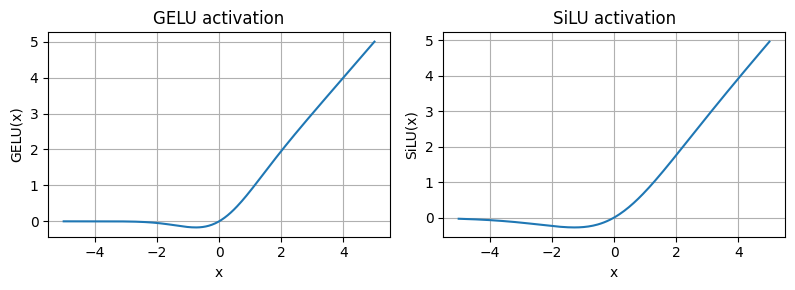

In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

gelu = nn.GELU()
silu = nn.SiLU()

x = torch.linspace(-5, 5, 200)

y_gelu = gelu(x)
y_silu = silu(x)

plt.figure(figsize=(12, 3))
for i, (y, label) in enumerate(zip(
    [y_gelu, y_silu], ["GELU", "SiLU"]), 1):
    plt.subplot(1, 3, i)
    plt.plot(x.numpy(), y.detach().numpy(), label=label)
    plt.title(f"{label} activation")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


# SwiGLU in Feedforward

In [32]:
class FeedForwardInGPT2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)
        self.silu = nn.SiLU()

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = self.silu(x_fc1) * x_fc2
        return self.fc3(x)

# RoPE

In [160]:
import torch

def precompute_rope_params(seq_len, head_dim):
    """
    Precompute sin and cos tensors for RoPE.

    Args:
        seq_len: sequence length
        head_dim: embedding dimension (must be even)

    Returns:
        sin, cos: tensors of shape (seq_len, dim//2)
    """
    half_dim = head_dim // 2
    inv_freq = 1.0 / (10000 ** (torch.arange(half_dim).float() / half_dim))
    positions = torch.arange(seq_len, dtype=torch.float32)
    angles = torch.einsum("i,j->ij", positions, inv_freq)  # (seq_len, half_dim)
    return torch.sin(angles), torch.cos(angles)


def rotary_pos_emb(x, sin, cos):
    """
    Apply Rotary Positional Embedding on input tensor x using precomputed sin and cos.

    Args:
        x: tensor of shape (batch, seq_len, dim)
        sin: precomputed sin tensor of shape (seq_len, dim//2)
        cos: precomputed cos tensor of shape (seq_len, dim//2)

    Returns:
        tensor same shape as x with RoPE applied.
    """
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch, num_heads, seq_len, head_dim = x.shape

    # x: (batch, seq_len, dim) -> (batch, seq_len, half_dim, 2)
    x_ = x.view(batch, num_heads, seq_len, head_dim // 2, 2)

    # ➤ Crop sin/cos to match actual seq_len
    sin = sin[:seq_len, :]
    cos = cos[:seq_len, :]

    x_rotated = torch.zeros_like(x_)
    x_rotated[..., 0] = x_[..., 0] * cos - x_[..., 1] * sin
    x_rotated[..., 1] = x_[..., 0] * sin + x_[..., 1] * cos

    return x_rotated.view_as(x)

In [136]:
# Example usage
batch_size, n_heads, seq_len, head_dim = 2, 4, 5, 16
x = torch.randn(batch_size, n_heads, seq_len, head_dim)
# Step 1: Precompute sin and cos for RoPE
sin, cos = precompute_rope_params(seq_len, head_dim)
# Step 2: Apply rotary positional embedding with precomputed sin and cos
x_rope = rotary_pos_emb(x, sin, cos)

print(x_rope.shape)  # Should be [2, 4, 5, 16]

Rotary Positional Embedding torch.Size([2, 4, 5, 16])
shape of x_ torch.Size([2, 4, 5, 8, 2])
shape of cos torch.Size([5, 8])
torch.Size([2, 4, 5, 16])


# update MHA with RoPE

In [161]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dtype=None):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # Use nn.Linear with shared kwargs to reduce repetition
        linear_kwargs = dict(bias=False, dtype=dtype)
        self.W_query = nn.Linear(d_in, d_out, **linear_kwargs)
        self.W_key = nn.Linear(d_in, d_out, **linear_kwargs)
        self.W_value = nn.Linear(d_in, d_out, **linear_kwargs)
        self.out_proj = nn.Linear(d_out, d_out, **linear_kwargs)

        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

        cos, sin = precompute_rope_params(seq_len=context_length, head_dim=self.head_dim)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Project inputs
        keys = self.W_key(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        queries = self.W_query(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.W_value(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        # Apply RoPE
        keys = rotary_pos_emb(keys, self.cos, self.sin)
        queries = rotary_pos_emb(queries, self.cos, self.sin)

        # Attention scores with causal mask
        attn_scores = queries @ keys.transpose(-2, -1)
        attn_scores.masked_fill_(self.mask[:num_tokens, :num_tokens], float('-inf'))

        attn_weights = torch.softmax(attn_scores / self.head_dim ** 0.5, dim=-1)

        context_vec = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


In [162]:
batch_size = 2
context_len = 128
max_context_len = 1280
embed_dim = 64
num_heads = 4

example_batch = torch.randn(batch_size, context_len, embed_dim)

mha = MultiHeadAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)

output = mha(example_batch)
print(output.shape)  # Expected: (batch_size, context_len, embed_dim)

torch.Size([2, 128, 64])


# Update TransformerBlock

In [163]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)

        self.norm1 = RMSNorm(cfg["emb_dim"])
        self.norm2 = RMSNorm(cfg["emb_dim"])
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut  # Add the original input back

        return x

# Update the Model

In [164]:
class Llama2Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = RMSNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

    def forward(self, in_idx):
        x = self.tok_emb(in_idx)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# Initialize Model

In [144]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,     # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11008,     # Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16
}

In [174]:
model = Llama2Model(LLAMA2_CONFIG_7B)


In [146]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 6,738,415,616


# Load Tokenizer

In [148]:
from huggingface_hub import login

# login(token="your hf token")


In [157]:
from huggingface_hub import hf_hub_download

tokenizer_file = hf_hub_download(
    repo_id="meta-llama/Llama-2-7b",
    filename="tokenizer.model",
    local_dir="Llama-2-7b"
)

In [166]:
import sentencepiece as spm

class LlamaTokenizer:
    def __init__(self, tokenizer_file):
        sp = spm.SentencePieceProcessor()
        sp.load(tokenizer_file)
        self.tokenizer = sp

    def encode(self, text):
        return self.tokenizer.encode_as_ids(text)

    def decode(self, ids):
        return self.tokenizer.decode_pieces(ids)


tokenizer = LlamaTokenizer(tokenizer_file)

In [175]:
from gpt2_v2 import generate_text_simple, text_to_tensor, tensor_to_text

torch.manual_seed(123)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor("At the start of", tokenizer).to("cpu"),
    max_new_tokens=30,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 At the start ofзей Warjarewnę обще Opera з went eeuwể Other collaborationlauf’Powerремħ’Powerремħ’ep kur extremely____dataset Multi vida curv


# Load pretrained Weights

In [155]:
weights_file = hf_hub_download(
   repo_id="meta-llama/Llama-2-7b",
   filename="consolidated.00.pth",
   local_dir="Llama-2-7b"
)

In [168]:
weights = torch.load(weights_file, weights_only=True)

In [169]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach()) if isinstance(right, torch.Tensor) else torch.nn.Parameter(torch.tensor(right))


def load_weights_into_llama(model, param_config, params):
    model.tok_emb.weight = assign(model.tok_emb.weight, params["tok_embeddings.weight"])

    for l in range(param_config["n_layers"]):
        block = model.trf_blocks[l]

        # map of attribute path (relative to block) -> param name
        attr_param_map = {
            f"att.W_query.weight": f"layers.{l}.attention.wq.weight",
            f"att.W_key.weight": f"layers.{l}.attention.wk.weight",
            f"att.W_value.weight": f"layers.{l}.attention.wv.weight",
            f"att.out_proj.weight": f"layers.{l}.attention.wo.weight",
            f"norm1.weight": f"layers.{l}.attention_norm.weight",
            f"ff.fc1.weight": f"layers.{l}.feed_forward.w1.weight",
            f"ff.fc2.weight": f"layers.{l}.feed_forward.w3.weight",  # swapped order
            f"ff.fc3.weight": f"layers.{l}.feed_forward.w2.weight",
            f"norm2.weight": f"layers.{l}.ffn_norm.weight",
        }

        for attr_path, param_name in attr_param_map.items():
            obj = block
            *parents, attr = attr_path.split('.')
            for p in parents:
                obj = getattr(obj, p)
            old_tensor = getattr(obj, attr)
            setattr(obj, attr, assign(old_tensor, params[param_name]))

    model.final_norm.weight = assign(model.final_norm.weight, params["norm.weight"])
    model.out_head.weight = assign(model.out_head.weight, params["output.weight"])


In [170]:
device = torch.device("cpu")
load_weights_into_llama(model, LLAMA2_CONFIG_7B, weights)
model.to(device);

In [172]:
from gpt2_v2 import generate_text_simple, text_to_tensor, tensor_to_text

torch.manual_seed(123)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor("At the start of", tokenizer).to("cpu"),
    max_new_tokens=30,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 At the start of the 20th century, the city was a major industrial center, with a large number of factories and mills. The city was also


In [176]:
del model

# try instruction-finetuned model

In [177]:
weights_file = hf_hub_download(
   repo_id="meta-llama/Llama-2-7b-chat",
   filename="consolidated.00.pth",
   local_dir="Llama-2-7b-chat"
)

In [ ]:
model = Llama2Model(LLAMA2_CONFIG_7B)
load_weights_into_llama(model, LLAMA2_CONFIG_7B, weights)
model.to(device)

In [180]:
from gpt2_v2 import generate_text_simple, text_to_tensor, tensor_to_text

torch.manual_seed(123)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor("What do llamas eat?", tokenizer).to(device),
    max_new_tokens=30,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 What do llamas eat?
Llamas are herbivores, which means they eat plants. They eat grass, hay, and other plants.
What do llam
